In [1]:
from db import connect_npsql, convert_array
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq



con = connect_npsql('results.db')
con.execute("PRAGMA journal_mode=WAL")
con.commit()

In [2]:
import io

def convert_sparray(txt):
    out = io.BytesIO(txt)
    out.seek(0)
    return np.load(out,allow_pickle=True)

In [3]:
def num_cells(lat):
    if type(lat) in [bytes, str]:
        lat = convert_sparray(lat)
    return int(abs(np.linalg.det(np.array(lat,dtype=np.float64)))/128)
        

In [4]:
res = con.execute("SELECT latvecs FROM field_111 GROUP BY latvecs")
lats = [x[0] for x in res.fetchall()]
res.close()

print("Loaded geometries: ")
for l in lats:
    print(convert_sparray(l))
    

Loaded geometries: 
[[0 8 8]
 [8 0 8]
 [8 8 0]]
[[-4 0 24]
 [-12 8 24]
 [0 8 0]]


In [5]:
num_cells(lats[1])

12

In [6]:
np.array(con.execute("""
        SELECT g0_g123 FROM field_111
        WHERE latvecs = ? AND g123_sign = ?
        GROUP BY g0_g123
        ORDER BY g0_g123
        """,
        (lats[1], 1)).fetchall())[:,0]

array([-3.001e+02, -2.901e+02, -2.801e+02, -2.701e+02, -2.601e+02,
       -2.501e+02, -2.401e+02, -2.301e+02, -2.201e+02, -2.101e+02,
       -2.001e+02, -1.901e+02, -1.801e+02, -1.701e+02, -1.601e+02,
       -1.501e+02, -1.401e+02, -1.301e+02, -1.201e+02, -1.101e+02,
       -1.101e+02, -1.001e+02, -1.001e+02, -9.010e+01, -8.010e+01,
       -7.010e+01, -6.010e+01, -5.010e+01, -4.010e+01, -3.010e+01,
       -2.010e+01, -1.010e+01, -3.050e+00, -2.950e+00, -2.850e+00,
       -2.750e+00, -2.650e+00, -2.550e+00, -2.450e+00, -2.350e+00,
       -2.250e+00, -2.150e+00, -2.050e+00, -1.950e+00, -1.850e+00,
       -1.750e+00, -1.650e+00, -1.550e+00, -1.450e+00, -1.350e+00,
       -1.250e+00, -1.150e+00, -1.050e+00, -9.500e-01, -8.500e-01,
       -7.500e-01, -6.500e-01, -5.500e-01, -4.500e-01, -3.500e-01,
       -2.500e-01, -1.500e-01, -1.000e-01, -5.000e-02,  5.000e-02,
        1.500e-01,  2.500e-01,  3.500e-01,  4.500e-01,  5.500e-01,
        6.500e-01,  7.500e-01,  8.500e-01,  9.500e-01,  1.050e

In [7]:
def get_sector_list(lat):
    retval = {}
    res = con.execute("""
        SELECT sector, count(sector)
        FROM field_111
        WHERE latvecs = ?
        GROUP BY sector
        """, (lat,))
    for sector, count in res:
        retval[sector] = count
        
    return retval


def find_groundstate_111(lat, sign=1):
    # if type(lat) == str:
    #     lat = convert_sparray(lat)
    
    # n_cell = int(abs(np.linalg.det(np.array(lat,dtype=float)) / 128))

    x_list = np.array(con.execute("""
        SELECT g0_g123 FROM field_111
        WHERE latvecs = ? AND g123_sign = ? 
        AND g0_g123 > -3 AND g0_g123 < 3
        GROUP BY g0_g123
        ORDER BY g0_g123
        """,
        (lat, sign)).fetchall())[:,0]

    sectors = list(get_sector_list(lat).keys())

    energy_list = []
    
    for sector in sectors:
        
        
        res = con.execute("""
        SELECT g0_g123, edata FROM field_111
        WHERE sector = ? AND latvecs = ? AND g123_sign = ? 
        AND g0_g123 > -3 AND g0_g123 < 3
        ORDER BY g0_g123
        """,
        (sector, lat, sign))
        
        tmp = []
        for x, e in res:
            e = convert_array(e)[0]
            tmp.append(e)

        assert len(tmp) == len(x_list), f"Lengths don't match - {len(tmp)} != {len(x_list)}"
        energy_list.append(tmp)

    best_sectors = []
    
    
    energy_list = np.array(energy_list).T

    sector_energies = []
    for x, E_set in zip(x_list, energy_list):
        best_sector_idx = np.argsort(E_set)[:5]
        best_sectors.append(best_sector_idx)
        sector_energies.append(E_set[best_sector_idx])

    return x_list, best_sectors, sector_energies, sectors
        
        
        

        
xx, sec, sec_E, sec_names = find_groundstate_111(lats[1])

In [8]:
sec_names[sec[15][0]]

'(6, 6, 6, 6)'

{np.int64(47): '(12, 4, 4, 4)', np.int64(14): '(0, 8, 8, 8)', np.int64(112): '(6, 6, 6, 6)'}


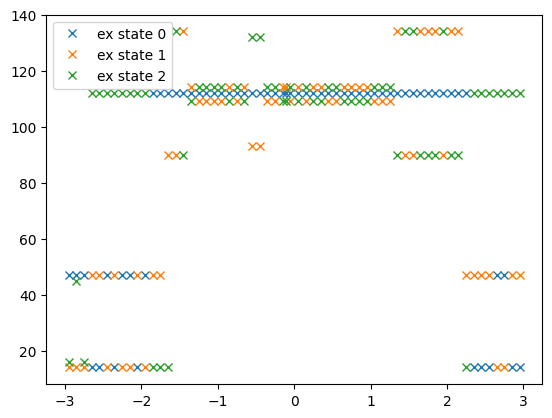

In [9]:
for J in range(3):
    plt.plot(xx, np.array(sec)[:,J],'x',label=f"ex state {J}")

plt.legend()

unique_sectors = {}
for sec_ids in sec:
    gs_sec_id = sec_ids[0]
    unique_sectors[gs_sec_id] = sec_names[gs_sec_id]

print(unique_sectors)

In [10]:
def cleanup_111(lat):
    res = con.execute("""
        SELECT g0_g123
        FROM field_111
        WHERE latvecs = ?
        GROUP BY g0_g123
        ORDER BY g0_g123
        """,(lat,)).fetchall()
    problems = np.argwhere(np.diff(np.array(res)[:,0]) < 1e-6)
    for J in problems:
        print(f"Deleting g0_g123 = {res[J[0]]}")
        con.execute("""
            DELETE FROM field_111
            WHERE g0_g123 = ?
            """, res[J[0]] )


def cleanup_110(lat):
    res = con.execute("""
        SELECT g01_g23
        FROM field_110
        WHERE latvecs = ?
        GROUP BY g01_g23
        ORDER BY g01_g23
        """,(lat,)).fetchall()
    problems = np.argwhere(np.diff(np.array(res)[:,0]) < 1e-6)
    for J in problems:
        print(f"Deleting g01_g23 = {res[J[0]]}")
        con.execute("""
            DELETE FROM field_110
            WHERE g01_g23 = ?
            """, res[J[0]] )
        
cleanup_111(lats[1])
cleanup_110(lats[1])

Deleting g0_g123 = (-110.10000000000002,)
Deleting g0_g123 = (-100.10000000000002,)
Deleting g01_g23 = (-110.10000000000002,)
Deleting g01_g23 = (-100.10000000000002,)


In [11]:
def _process_data(res):
    x_list = []
    E_list = []
    expO_list = []
    
    tmp = res.fetchone()
    
    while tmp is not None: 
        x_list.append(tmp[0])
        E_list.append(convert_array(tmp[1]))
        expO_list.append([convert_array(x) for x in tmp[2:]])
        tmp = res.fetchone()
    
    E_list = np.array(E_list)

    return x_list, E_list, expO_list
    


def import_data_111(g123_sign:int, latvecs, sector):
    res = con.execute(f"""
    SELECT g0_g123, edata, expO0, expO1, expO2, expO3 
    FROM field_111
    WHERE g123_sign = ? AND latvecs = ? AND sector = ?
    ORDER BY g0_g123
    """, (g123_sign, latvecs, str(sector) ))
    return _process_data(res)
   


def import_data_110(g23_sign:int, latvecs, sector):
    res = con.execute(f"""
    SELECT g01_g23, edata, expO0, expO1, expO2, expO3 
    FROM field_110
    WHERE g23_sign = ? AND latvecs = ? AND sector = ?
    ORDER BY g01_g23
    """, (g23_sign, latvecs, str(sector) ))
    return _process_data(res)





In [12]:
def process_expO(raw):
    return [
        [np.mean(np.real(np.linalg.eigvals(O[sl]))) for O in raw]
        for sl in range(4)
    ]
    


class RingInterpolator:
    def __init__(self, data_importer, interpolation_f=CubicSpline):
    
        x_list_plus, E_list_plus, expO_list_plus = data_importer(1)
        expO_series_plus = process_expO(expO_list_plus)
    
        x_list_minus, E_list_minus, expO_list_minus = data_importer(-1)
        expO_series_minus = process_expO(expO_list_minus)

        E_list_plus = np.sort(E_list_plus, axis=-1)
        E_list_minus = np.sort(E_list_minus, axis=-1)
    
        self.ring_interpolators = {
             1: [ interpolation_f(x_list_plus, expO_series_plus[sl]) for sl in range(4)],
            -1: [ interpolation_f(x_list_minus, expO_series_minus[sl]) for sl in range(4)]
        }

        self.gse_interpolators = {
             1 : interpolation_f(x_list_plus, np.array(E_list_plus)[:,0]),
            -1 : interpolation_f(x_list_minus, np.array(E_list_minus)[:,0])
        }

        self.es1_interpolators = {
             1 : interpolation_f(x_list_plus, np.array(E_list_plus)[:,1]),
            -1 : interpolation_f(x_list_minus, np.array(E_list_minus)[:,1])
        }

        self.x_list = {1: x_list_plus, -1:x_list_minus}
        self.E_list = {1: E_list_plus, -1:E_list_minus}
        self.expO_series = {1: expO_series_plus, -1: expO_series_minus}
    
        assert all(np.diff(x_list_plus) > 1e-10)
        assert all(np.diff(x_list_minus) > 1e-10)
            
    def interpolate_ring(self, sign, x, check=True):
        if x > np.max(self.x_list[sign]):
            if check:
                return [np.nan, np.nan, np.nan, np.nan]
            return self.expO_series[-1]
        elif x < np.min(self.x_list[sign]):
            if check:
                return [np.nan, np.nan, np.nan, np.nan]
            return self.expO_series[0]
            
        return [self.ring_interpolators[sign][j](x) for j in range(4)]

    def check_g_compatible(self, g):
        raise NotImplementedError()
    
    def O(self, g, check=True):
        self.check_g_compatible(g)
        x = g[0] / g[3]
        
        if g[3] >= 0:
            return self.interpolate_ring(1, x, check)
        else:
            return self.interpolate_ring(-1, x, check)
            
    def gap(self, g, check=True):
        self.check_g_compatible(g)
        
        x = g[0]/ g[3]
        
        sign = 1 if g[3] >= 0 else -1
        
        e1 = self.es1_interpolators[sign](x)
        e0 = self.gse_interpolators[sign](x)

        if x > np.max(self.x_list[sign]):
            # if check:
            return np.nan
            
        elif x < np.min(self.x_list[sign]):
            # if check:
            return np.nan
            
        
        # rescale by g[3]
        e1 *= np.abs(g[3])
        e0 *= np.abs(g[3])
        return e1 - e0


# trivial specilisations
class RingInterpolator_111(RingInterpolator):
    def __init__(self, latvecs, sector, **kwargs):
        super().__init__(lambda g : import_data_111(g, latvecs, sector), **kwargs)

    def check_g_compatible(self, g):
        assert g[1] == g[2] and g[1] == g[3]


class RingInterpolator_110(RingInterpolator):
    def __init__(self, latvecs, sector, **kwargs):
        super().__init__(lambda g : import_data_110(g, latvecs, sector),**kwargs)

    def check_g_compatible(self, g):
        assert g[0] == g[1] and g[2] == g[3]


In [13]:
R3 = np.sqrt(3)

def Jring(Jpm, B):
    # assumes units of Jy
    
    ring_normals = np.array([ [1.,1,1], [1,-1,-1],[-1,1,-1],[-1,-1,1]])/R3
    
    return (3/2) * Jpm**3 - (5/4) * Jpm**2 * (ring_normals @ B)**2




cm = matplotlib.colormaps['bwr']




def calc_phasedia_data(rfi: RingInterpolator, field_direction, 
                       resolution = (128,64), 
                       jpm_limits=(-0.1,0.1),
                       B_limits =(0,0.5)
                      ):
    
    jpm_arr = np.linspace(*jpm_limits,resolution[0])
    B_arr   = np.linspace(*B_limits, resolution[1])

    rf_vals = np.empty((4,resolution[1],resolution[0]))
    gap_vals = np.empty((resolution[1],resolution[0]))
    x_vals = np.empty((resolution[1],resolution[0]))

    rf_vals[:] = np.nan
    gap_vals[:] = np.nan

    field_direction /= np.linalg.norm(field_direction)
    
    for i, jpm in enumerate(jpm_arr):
        for j, b in enumerate(B_arr):
            g = Jring(jpm, b*field_direction)
            rf_vals[:,j,i] = rfi.O( g, check=True )
            gap_vals[j,i] = rfi.gap(g, check=True)
            x_vals[j, i] = g[0]/g[3]
            
    return jpm_arr, B_arr, rf_vals, gap_vals, x_vals


In [14]:

def add_phasedia_boundaries(a, jpm_arr, B_arr, B_direction, **kwargs):
    B = np.array(B_direction,dtype=np.float64)
    B /= np.linalg.norm(B)

    f0 = lambda j,b : Jring(j, b*B)[0] + 0.5*sum(Jring(j, b*B)[1:3])
    f1 = lambda j,b : Jring(j, b*B)[1]


    
    sing_vals_0 = []
    sing_vals_1 = []
    for bb in B_arr:
        res0, res1 = None, None
        try:
            res0 = brentq(f0, 0.00001, np.max(jpm_arr)*2,args=bb)
            try:
                res1 = brentq(f1, res0*0.01, res0*0.9,args=bb)
            except ValueError:
                res1 =  None
        except ValueError:
            res0 =  None

       
        
        sing_vals_0.append(res0)
        sing_vals_1.append(res1)
            
    
    a.axvline(0,**kwargs)
    a.plot(sing_vals_0, B_arr, **kwargs)
    a.plot(sing_vals_1, B_arr, **kwargs)
    # a.plot( 0.455 * B_arr**2,B_arr, **kwargs)
    # a.plot( 0.09 * B_arr**2,B_arr, **kwargs)
    a.set_xlim([np.min(jpm_arr), np.max(jpm_arr)])

In [15]:
# Check quality of interpolation



def plot_interp_quality(rfi, x_lims = [-4.2, 4.2], recip=False):
    fig, Ax = plt.subplots(2,2, sharey=True)
    Ax2 = np.array([[ax.twinx() for ax in row] for row in Ax])

    power = -1 if recip else 1
    
    Ax[0,0].set_title(r'$g_{1,2,3}>0$')
    Ax[0,0].plot(np.array(rfi.x_list[1])**power, np.array(rfi.expO_series[1]).T,'.')
    
    
    Ax[0,1].plot(np.array(rfi.x_list[-1])**power, np.array(rfi.expO_series[-1]).T,'.')
    Ax[0,1].set_title(r'$g_{1,2,3}<0$')
    
    Ax[1,0].plot(np.array(rfi.x_list[1])**power, np.array(rfi.expO_series[1]).T,'.')
    Ax[1,1].plot(np.array(rfi.x_list[-1])**power, np.array(rfi.expO_series[-1]).T,'.')
    
    xx = np.linspace(np.min(rfi.x_list[1]), np.max(rfi.x_list[1]), 120)
    
    xx_detail = np.linspace(*x_lims, 120)
    
    for i, xax in enumerate([xx, xx_detail]):
        Ax[i,0].plot(xax, [rfi.interpolate_ring(1, x**power) for x in xax])
        Ax[i,1].plot(xax, [rfi.interpolate_ring(-1, x**power) for x in xax])
    
    for a in Ax[1]:
        a.set_xlim(x_lims)
        a.set_ylim([-0.5,0.5])

    xl = r'$g_{1,2,3}/g_0$' if recip else r'$g_0/g_{1,2,3}$'
    
    Ax[1,0].set_xlabel(xl)
    Ax[1,1].set_xlabel(xl)


def plot_E_interp_quality(rfi, x_lims = [-4.2, 4.2]):
    fig, Ax = plt.subplots(2,2)
    # Ax2 = np.array([[ax.twinx() for ax in row] for row in Ax])
 
    Ax[0,0].set_title(r'$g_{1,2,3}>0$')
    # Ax[0,0].plot(rfi.x_list[1], rfi.E_list[1]-rfi.E_list[1][0,:],'.')
    # Ax[1,0].plot(rfi.x_list[1], rfi.E_list[1]-rfi.E_list[1][0,:],'.')

    Ax[0,0].plot(rfi.x_list[1], rfi.E_list[1][:, 0:2],'.')
    Ax[1,0].plot(rfi.x_list[1], rfi.E_list[1][:, 0:2],'.')
    
    Ax[0,1].set_title(r'$g_{1,2,3}<0$')
    Ax[0,1].plot(rfi.x_list[-1], rfi.E_list[-1]-rfi.E_list[-1][0,:],'.')
    Ax[1,1].plot(rfi.x_list[-1], rfi.E_list[-1]-rfi.E_list[-1][0,:],'.')
    
    
    
    xx = np.linspace(np.min(rfi.x_list[1]), np.max(rfi.x_list[1]), 120)
    
    xx_detail = np.linspace(*x_lims, 120)
    
    for i, xax in enumerate([xx, xx_detail]):
        # Ax[i,0].plot(xax, [rfi.es1_interpolators[1](x)-rfi.gse_interpolators[1](x) for x in xax],color='k')
        
        # Ax[i,1].plot(xax, [rfi.es1_interpolators[-1](x)-rfi.gse_interpolators[-1](x) for x in xax],color='k')
        Ax[i,0].plot(xax, [rfi.gse_interpolators[1](x) for x in xax],color='k')
        Ax[i,0].plot(xax, [rfi.es1_interpolators[1](x) for x in xax],color='r')
        
        Ax[i,1].plot(xax, [rfi.gse_interpolators[-1](x) for x in xax],color='k')
        Ax[i,1].plot(xax, [rfi.es1_interpolators[-1](x) for x in xax],color='r')
    
    for a in Ax[1]:
        a.set_xlim(x_lims)
        a.set_ylim([-12,-4])

    # for a in Ax[0]:
    #     # a.set_xlim(x_lims)
    #     a.set_ylim([0,2])
    
    Ax[1,0].set_xlabel(r'$g_0/g_{1,2,3}$')
    Ax[1,1].set_xlabel(r'$g_0/g_{1,2,3}$')



/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


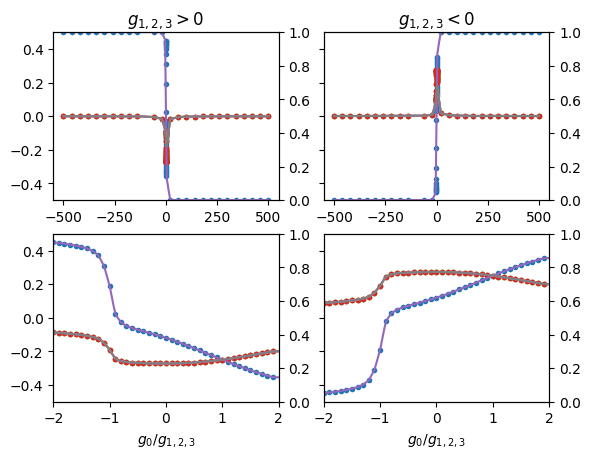

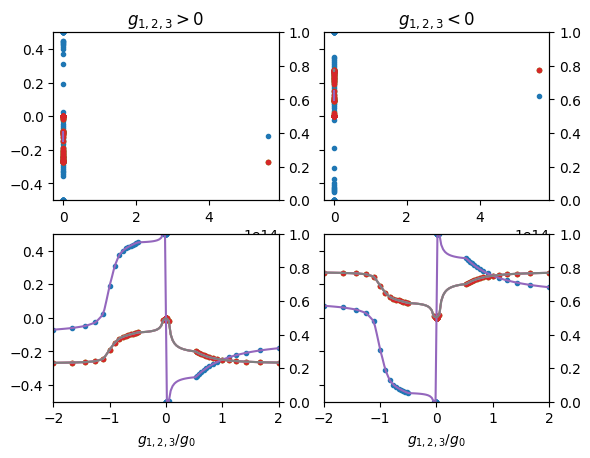

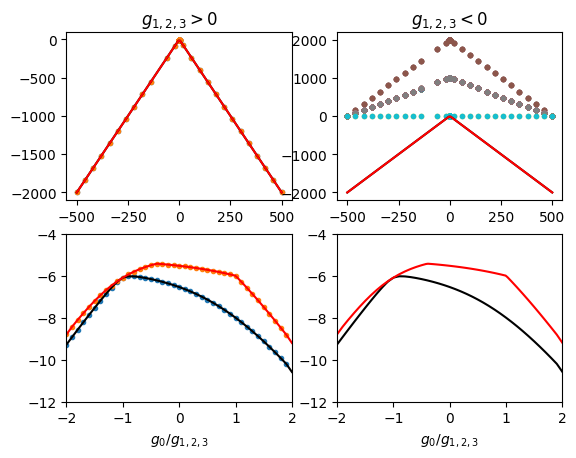

In [16]:
# from scipy.interpolate import L
LinearInterpolator = lambda X,Y : lambda x : np.interp(x,X,Y)

lattice = lats[0]

sector = (4,4,4,4)
# sector = (6,6,6,6)
# sector = (12, 6,6,6)

rfi = RingInterpolator_111(lattice, sector, interpolation_f=LinearInterpolator)
plot_interp_quality(rfi, x_lims = [-2,2])
plot_interp_quality(rfi, x_lims = [-2,2], recip=True)
plot_E_interp_quality(rfi, x_lims = [-2,2])

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_38060/3289976110.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  gap_vals[j,i] = rfi.gap(g, check=True)


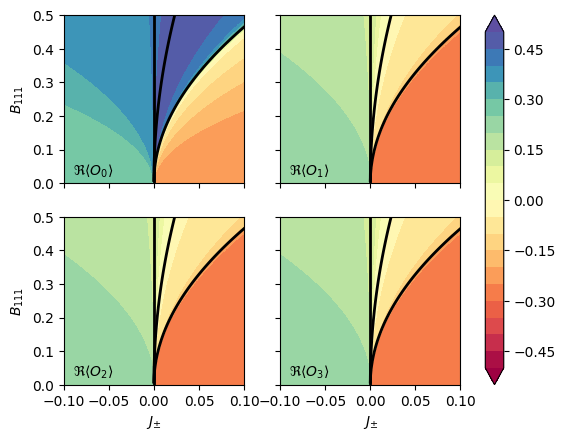

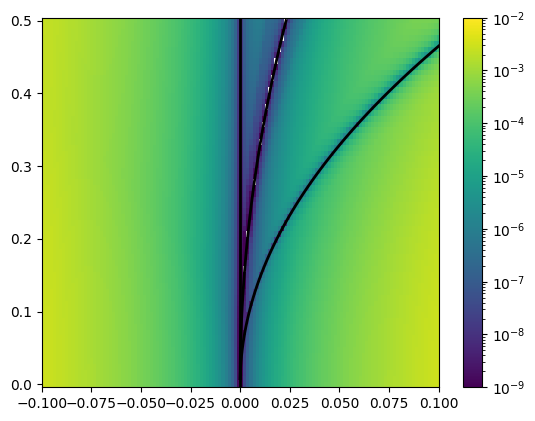

In [17]:
from matplotlib import colors

jpm_arr, B_arr, rf_vals, gap_vals, x_vals = calc_phasedia_data(rfi = rfi, field_direction = [1,1,1])

fig, Ax = plt.subplots(2,2, sharex=True, sharey=True)#, figsize=(3.5,3))
c = []
for sl, ax in enumerate(Ax.ravel()):

    # ax = Ax[ij]
    c.append(
        ax.contourf(jpm_arr, B_arr, rf_vals[sl],
                    extend='both',
                            levels=np.linspace(-0.5,0.5,21),
                          cmap='Spectral')
    )

    ax.text(0.05,0.05,rf"$\Re \langle O_{sl} \rangle$",transform=ax.transAxes)

Ax[1,0].set_xlabel(r"$J_{\pm}$")
Ax[1,1].set_xlabel(r"$J_{\pm}$")
Ax[0,0].set_ylabel(r"$B_{111}$")
Ax[1,0].set_ylabel(r"$B_{111}$")


for a in Ax.ravel():
    add_phasedia_boundaries(a,jpm_arr, B_arr, [1,1,1], color='k',lw=2)


fig.colorbar(c[0],ax=Ax)
fig.savefig("/Users/alaricsanders/Desktop/222_B111_ED_ring_phase_dia.pdf")


n = matplotlib.colors.LogNorm(vmin=1e-9, vmax=0.01, clip=True)
fig, ax = plt.subplots()
c = ax.pcolormesh(jpm_arr, B_arr, gap_vals,norm=n)
fig.colorbar(c)
add_phasedia_boundaries(ax,jpm_arr, B_arr, [1,1,1], color='k',lw=2)

# fig.savefig("~/Desktop/222_ED_ring_phase_dia.png")
# # cax = fig.add_axes([0.9,0.4,0.05,0.4])
# fig, ax = plt.subplots()
# c = ax.pcolormesh(jpm_arr, B_arr, x_vals, vmin=-4, vmax=4, cmap='RdYlBu')
# fig.colorbar(c)

/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


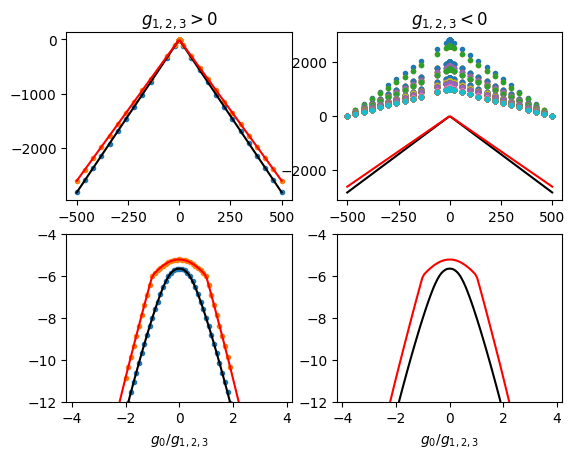

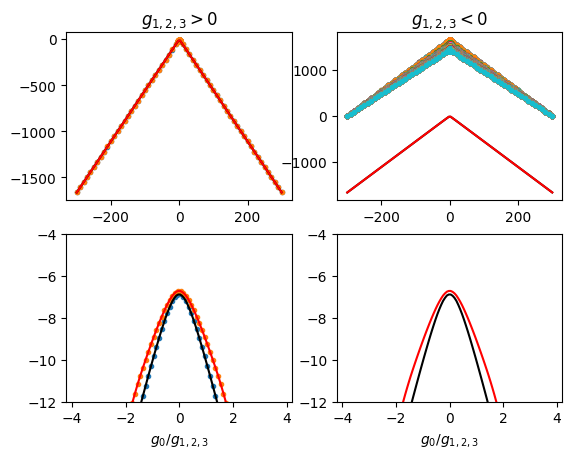

In [18]:
rfi_110 = RingInterpolator_110(lats[0],(4,4,4,4),interpolation_f=LinearInterpolator )

plot_E_interp_quality(rfi_110)

rfi_110 = RingInterpolator_110(lats[1],(6,6,6,6),interpolation_f=LinearInterpolator )

plot_E_interp_quality(rfi_110)

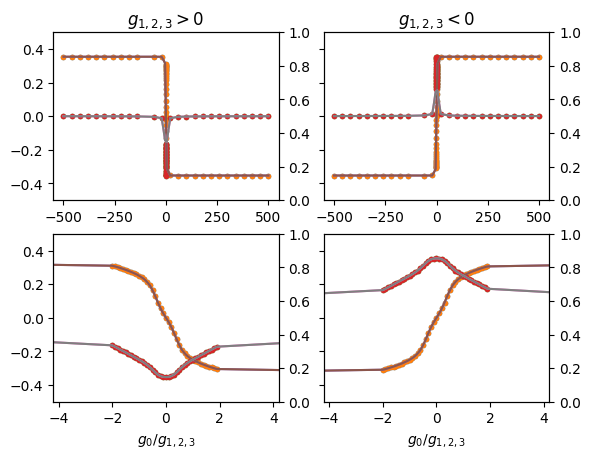

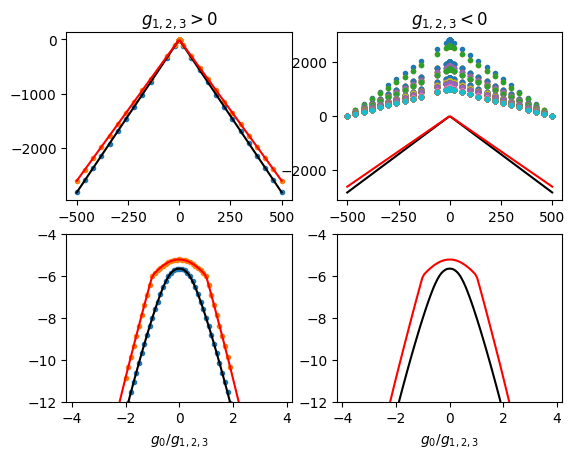

In [19]:
rfi_110 = RingInterpolator_110(lats[0],(4,4,4,4),interpolation_f=LinearInterpolator )
# rfi_110 = RingInterpolator_110(lats[1],(6,6,6,6),interpolation_f=LinearInterpolator )

plot_interp_quality(rfi_110)
plot_E_interp_quality(rfi_110)

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_38060/3289976110.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  gap_vals[j,i] = rfi.gap(g, check=True)


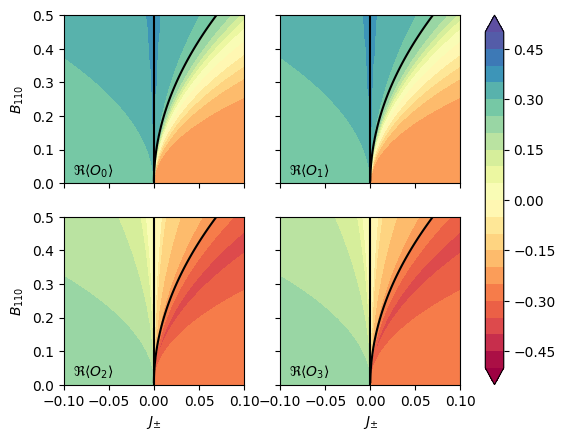

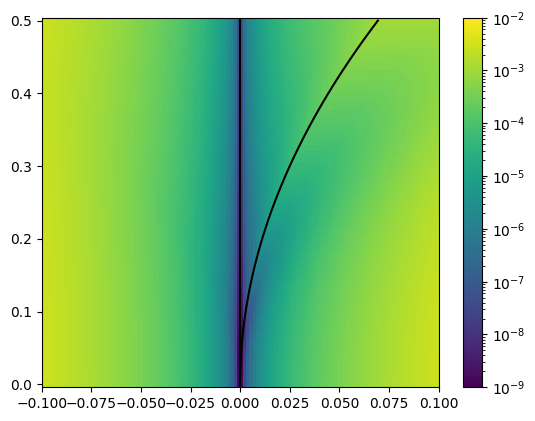

In [20]:
jpm_arr, B_arr, rf_vals, gap_vals, _ = calc_phasedia_data(rfi = rfi_110, field_direction = [0,1,1])

fig, Ax = plt.subplots(2,2, sharex=True, sharey=True)#, figsize=(3.5,3))
c = []
for sl, ax in enumerate(Ax.ravel()):

    # ax = Ax[ij]
    c.append(
        ax.contourf(jpm_arr, B_arr, rf_vals[sl],
                       extend='both',
                            levels=np.linspace(-0.5,0.5,21),
                          cmap='Spectral')
    )

    ax.text(0.05,0.05,rf"$\Re \langle O_{sl} \rangle$",transform=ax.transAxes)

Ax[1,0].set_xlabel(r"$J_{\pm}$")
Ax[1,1].set_xlabel(r"$J_{\pm}$")
Ax[0,0].set_ylabel(r"$B_{110}$")
Ax[1,0].set_ylabel(r"$B_{110}$")


for a in Ax.ravel():
    add_phasedia_boundaries(a,jpm_arr, B_arr, [1,1,0],color='k')

fig.colorbar(c[0],ax=Ax)

fig.savefig("/Users/alaricsanders/Desktop/222_B110_ED_ring_phase_dia.pdf")


n = matplotlib.colors.LogNorm(vmin=1e-9, vmax=0.01, clip=True)
fig, ax = plt.subplots()
c = ax.pcolormesh(jpm_arr, B_arr, gap_vals,norm=n)
fig.colorbar(c)
add_phasedia_boundaries(ax,jpm_arr, B_arr, [1,1,0],color='k')